#UIDAI DATA-DRIVEN AADHAAR CAMPAIGN PRIORITIZATION FRAMEWORK
By Aaradhya Shekdar
TEAM_ID- UIDAI_12217

#**#Problem statement : “How can Aadhaar outreach campaigns be prioritized across Indian states based on population age structure and enrollment patterns to maximize impact?”**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import glob
import pandas as pd

demo_files = glob.glob(
    "/content/drive/MyDrive/UIDAI HACKATHON/api_data_aadhar_demographic/*.csv"
)

df_demo = pd.concat([pd.read_csv(f) for f in demo_files], ignore_index=True)

df_demo.shape

df_demo.head()
df_demo.columns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_'],
      dtype='object')

In [ ]:
import pandas as pd

# clean date
df_demo['date'] = pd.to_datetime(df_demo['date'], errors='coerce')

# clean state
df_demo['state_clean'] = (
    df_demo['state']
    .astype(str)
    .str.lower()
    .str.strip()
)


/tmp/ipython-input-159676859.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_demo['date'] = pd.to_datetime(df_demo['date'], errors='coerce')


In [ ]:
df_demo[['state', 'state_clean']].head()


,state,state_clean
0,Maharashtra,maharashtra
1,Maharashtra,maharashtra
2,Maharashtra,maharashtra
3,Maharashtra,maharashtra
4,Maharashtra,maharashtra


In [ ]:
df_demo['age_5_17'] = df_demo['demo_age_5_17']
df_demo['age_18_plus'] = df_demo['demo_age_17_']
state_age = (
    df_demo
    .groupby('state_clean')[['age_5_17', 'age_18_plus']]
    .sum()
    .reset_index()
)

state_age.head()


,state_clean,age_5_17,age_18_plus
0,100000,0,2
1,andaman & nicobar islands,13,1046
2,andaman and nicobar islands,604,5583
3,andhra pradesh,321148,1974434
4,arunachal pradesh,5783,30660


In [ ]:
state_age['dominant_age_group'] = state_age[['age_5_17', 'age_18_plus']].idxmax(axis=1)
campaign_map = {
    'age_5_17': 'Education & Science Camps',
    'age_18_plus': 'Youth & Skill Development Camps'
}

state_age['recommended_campaign'] = state_age['dominant_age_group'].map(campaign_map)
state_age.head()


,state_clean,age_5_17,age_18_plus,dominant_age_group,recommended_campaign
0,100000,0,2,age_18_plus,Youth & Skill Development Camps
1,andaman & nicobar islands,13,1046,age_18_plus,Youth & Skill Development Camps
2,andaman and nicobar islands,604,5583,age_18_plus,Youth & Skill Development Camps
3,andhra pradesh,321148,1974434,age_18_plus,Youth & Skill Development Camps
4,arunachal pradesh,5783,30660,age_18_plus,Youth & Skill Development Camps


ENROLLEMENT

In [ ]:
# clean date
df_enroll['date'] = pd.to_datetime(df_enroll['date'], errors='coerce')

# clean state
df_enroll['state_clean'] = (
    df_enroll['state']
    .astype(str)
    .str.lower()
    .str.strip()
)

# extract month
df_enroll['enroll_month'] = df_enroll['date'].dt.month
state_month_enroll = (
    df_enroll
    .groupby(['state_clean', 'enroll_month'])
    .size()
    .reset_index(name='enroll_count')
)

state_month_enroll.head()


,state_clean,enroll_month,enroll_count
0,100000,2.0,1
1,100000,3.0,1
2,100000,8.0,1
3,100000,9.0,1
4,100000,11.0,1


# Define summer so see if kids do fill enrolement form when they are free from school

In [ ]:
summer_months = [4, 5, 6]  # Apr–Jun
state_month_enroll['season'] = state_month_enroll['enroll_month'].apply(
    lambda m: 'summer' if m in summer_months else 'non_summer'
)
seasonal_enroll = (
    state_month_enroll
    .groupby(['state_clean', 'season'])['enroll_count']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

seasonal_enroll.head()


season,state_clean,non_summer,summer
0,100000,6,0
1,andaman & nicobar islands,22,6
2,andaman and nicobar islands,79,16
3,andhra pradesh,16441,4677
4,arunachal pradesh,419,127


In [ ]:
seasonal_enroll['summer_ratio'] = (
    seasonal_enroll['summer'] /
    (seasonal_enroll['summer'] + seasonal_enroll['non_summer'])
)


# Using age dominace to pridict which area need which kind of campaign

In [ ]:
#merge
final_df = state_age.merge(
    seasonal_enroll[['state_clean', 'summer_ratio']],
    on='state_clean',
    how='left'
)

final_df.head()


,state_clean,age_5_17,age_18_plus,dominant_age_group,recommended_campaign,summer_ratio
0,100000,0,2,age_18_plus,Youth & Skill Development Camps,0.000000
1,andaman & nicobar islands,13,1046,age_18_plus,Youth & Skill Development Camps,0.214286
2,andaman and nicobar islands,604,5583,age_18_plus,Youth & Skill Development Camps,0.168421
3,andhra pradesh,321148,1974434,age_18_plus,Youth & Skill Development Camps,0.221470
4,arunachal pradesh,5783,30660,age_18_plus,Youth & Skill Development Camps,0.232601


In [ ]:
def decide_campaign(row):
    if row['dominant_age_group'] == 'age_5_17':
        if row['summer_ratio'] >= 0.4:
            return 'School-Holiday Aadhaar & Education Camps'
        else:
            return 'Education Awareness & Doorstep Enrollment Camps'

    elif row['dominant_age_group'] == 'age_18_plus':
        return 'Youth Skill & Employment Camps'

    else:
        return 'Routine Enrollment Services'

final_df['final_campaign'] = final_df.apply(decide_campaign, axis=1)


In [ ]:
final_df['dominant_age_label'] = final_df['dominant_age_group'].map({
    'age_5_17': 'School Age (5–17)',
    'age_18_plus': 'Adult & Youth (18+)'
})


In [ ]:
final_df[['state_clean',
          'dominant_age_label',
          'summer_ratio',
          'final_campaign']].head(10)


,state_clean,dominant_age_label,summer_ratio,final_campaign
0,100000,Adult & Youth (18+),0.000000,Youth Skill & Employment Camps
1,andaman & nicobar islands,Adult & Youth (18+),0.214286,Youth Skill & Employment Camps
2,andaman and nicobar islands,Adult & Youth (18+),0.168421,Youth Skill & Employment Camps
3,andhra pradesh,Adult & Youth (18+),0.221470,Youth Skill & Employment Camps
4,arunachal pradesh,Adult & Youth (18+),0.232601,Youth Skill & Employment Camps
5,assam,Adult & Youth (18+),0.226567,Youth Skill & Employment Camps
6,balanagar,Adult & Youth (18+),NaN,Youth Skill & Employment Camps
7,bihar,Adult & Youth (18+),0.212985,Youth Skill & Employment Camps
8,chandigarh,Adult & Youth (18+),0.221402,Youth Skill & Employment Camps
9,chhatisgarh,Adult & Youth (18+),NaN,Youth Skill & Employment Camps


In [ ]:
(state_age['age_18_plus'] > state_age['age_5_17']).value_counts()


,count
True,58


In [ ]:
state_age['child_share'] = (
    state_age['age_5_17'] /
    (state_age['age_5_17'] + state_age['age_18_plus'])
)
state_age['child_share'].describe()


,child_share
count,58.000000
mean,0.086137
std,0.059964
min,0.000000
25%,0.054011
50%,0.084432
75%,0.135739
max,0.239756


In [ ]:

cutoff = state_age['child_share'].quantile(0.75)

cutoff

state_age['dominant_age_group_ratio'] = state_age['child_share'].apply(
    lambda x: 'School Age (5–17)' if x >= cutoff else 'Adult & Youth (18+)'
)


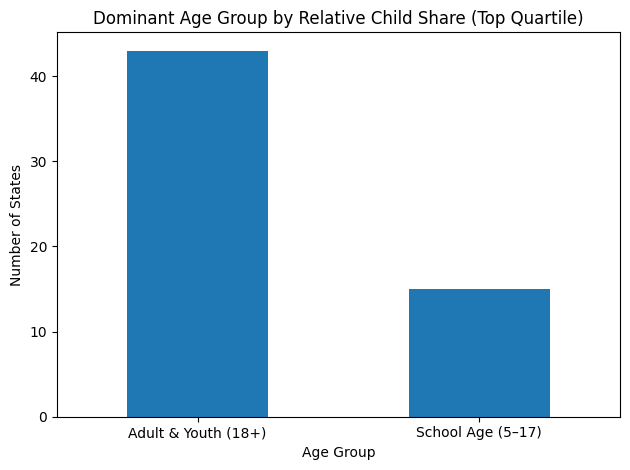

In [ ]:
# ploting Graphs using our AGE VS CAMPS DATA
state_age['dominant_age_group_ratio'].value_counts().plot(kind='bar')

plt.title('Dominant Age Group by Relative Child Share (Top Quartile)')
plt.xlabel('Age Group')
plt.ylabel('Number of States')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#dividing parts of india into 6 regions

South

North East

North West

Central

Middle India (East / Central-East belt)

UTs

In [ ]:
region_map.update({

    # UTs
    'andaman and nicobar islands': 'UTs',
    'puducherry': 'UTs',

    # Middle India (East)
    'odisha': 'Middle India',
    'west bengal': 'Middle India',

    # North West
    'uttarakhand': 'North West'
})



In [ ]:
state_level_df = (
    final_df[['state_clean', 'final_campaign']]
    .drop_duplicates()
)

# keep only official states/UTs
state_level_df = state_level_df[
    state_level_df['state_clean'].isin(official_states_uts)
]
print(state_level_df['state_clean'].nunique())


36


In [ ]:
state_level_df['region'] = state_level_df['state_clean'].map(region_map)
state_level_df[state_level_df['region'].isna()]['state_clean']


,state_clean


In [ ]:
region_campaign = (
    state_level_df
    .groupby(['region', 'final_campaign'])
    .size()
    .unstack(fill_value=0)
)

region_campaign



final_campaign,Youth Skill & Employment Camps
region,
Central,6
Middle India,4
North East,8
North West,8
South,6
UTs,4


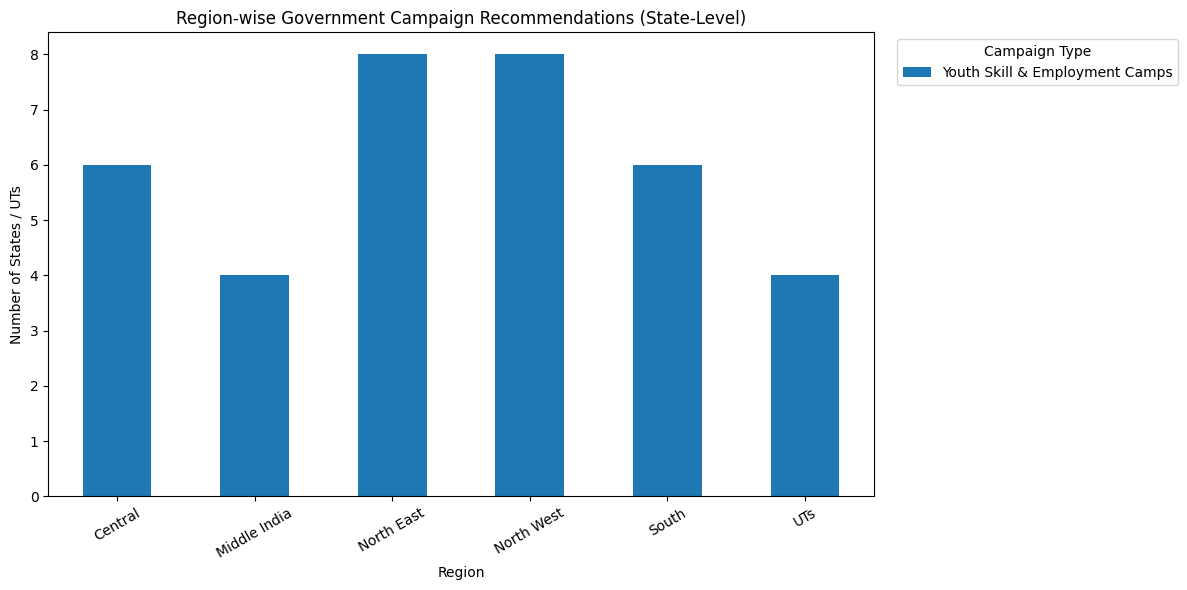

In [ ]:
import matplotlib.pyplot as plt

region_campaign.plot(kind='bar', figsize=(12,6))

plt.title('Region-wise Government Campaign Recommendations (State-Level)')
plt.xlabel('Region')
plt.ylabel('Number of States / UTs')
plt.xticks(rotation=30)
plt.legend(title='Campaign Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



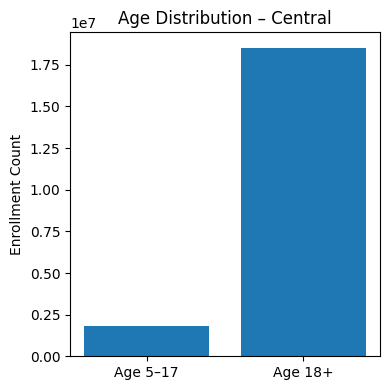

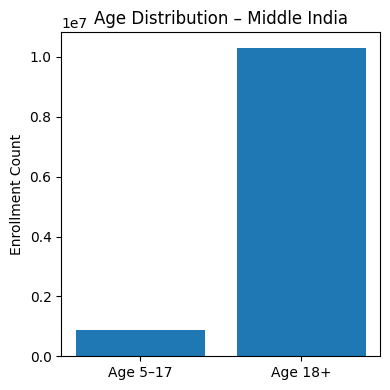

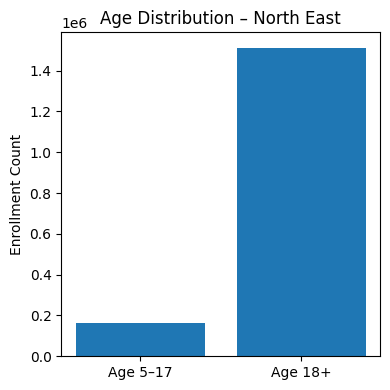

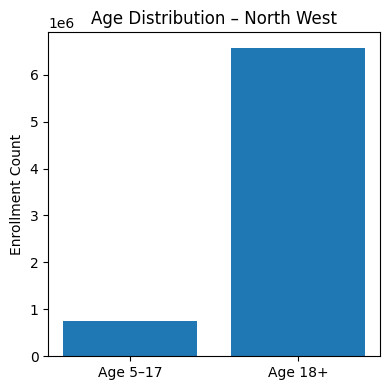

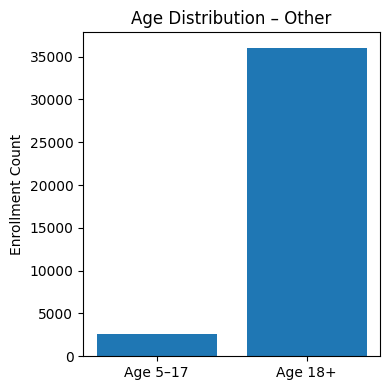

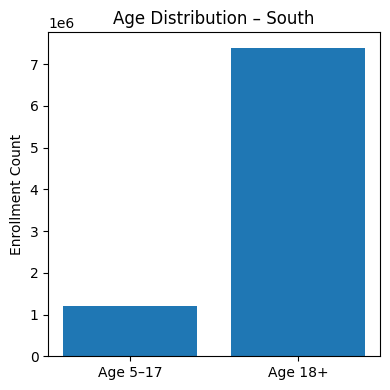

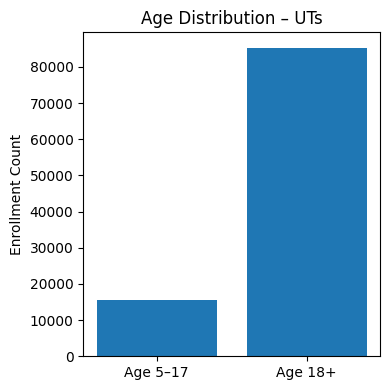

In [ ]:
for _, row in region_age.iterrows():
    plt.figure(figsize=(4,4))
    plt.bar(['Age 5–17', 'Age 18+'], [row['age_5_17'], row['age_18_plus']])
    plt.title(f"Age Distribution – {row['region']}")
    plt.ylabel('Enrollment Count')
    plt.tight_layout()
    plt.show()


# creation of heatma for campagins csv

In [ ]:
final_df.columns
final_df['child_share'] = (
    final_df['age_5_17'] /
    (final_df['age_5_17'] + final_df['age_18_plus'])
)


In [ ]:
cutoff = final_df['child_share'].quantile(0.75)

final_df['dominant_age_group_ratio'] = final_df['child_share'].apply(
    lambda x: 'Adult & Youth (18+)' if x < cutoff else 'School Age (5–17)'
)


In [ ]:
heatmap_table = (
    state_level_df
    .merge(
        final_df[['state_clean', 'child_share', 'summer_ratio', 'dominant_age_group_ratio']],
        on='state_clean',
        how='left'
    )
    .drop_duplicates()
)


In [ ]:
heatmap_table[['state_clean', 'child_share', 'summer_ratio', 'dominant_age_group_ratio']].head()


,state_clean,child_share,summer_ratio,dominant_age_group_ratio
0,andaman and nicobar islands,0.097624,0.168421,Adult & Youth (18+)
1,andhra pradesh,0.139898,0.221470,School Age (5–17)
2,arunachal pradesh,0.158686,0.232601,School Age (5–17)
3,assam,0.083431,0.226567,Adult & Youth (18+)
4,bihar,0.078935,0.212985,Adult & Youth (18+)


In [ ]:
heatmap_table['child_norm'] = heatmap_table['child_share'] / heatmap_table['child_share'].max()
heatmap_table['summer_gap'] = 1 - heatmap_table['summer_ratio']

heatmap_table['heat_score'] = (
    0.6 * heatmap_table['child_norm'] +
    0.4 * heatmap_table['summer_gap']
) * 100


In [ ]:
def campaign_color(row):
    if row['dominant_age_group_ratio'] == 'Adult & Youth (18+)':
        return 'Blue'
    else:
        return 'Red' if row['heat_score'] >= 70 else 'Orange'

heatmap_table['color_code'] = heatmap_table.apply(campaign_color, axis=1)
heatmap_table.shape
heatmap_table['color_code'].value_counts()


,count
color_code,
Blue,24
Orange,7
Red,5


In [ ]:
final_heatmap = heatmap_table[[
    'state_clean',
    'region',
    'color_code',
    'final_campaign',
    'heat_score'
]].sort_values('heat_score', ascending=False)
final_heatmap = final_heatmap.rename(
    columns={'final_campaign': 'campaign_focus'}
)


In [ ]:
final_heatmap.to_csv('india_campaign_heatmap.csv', index=False)


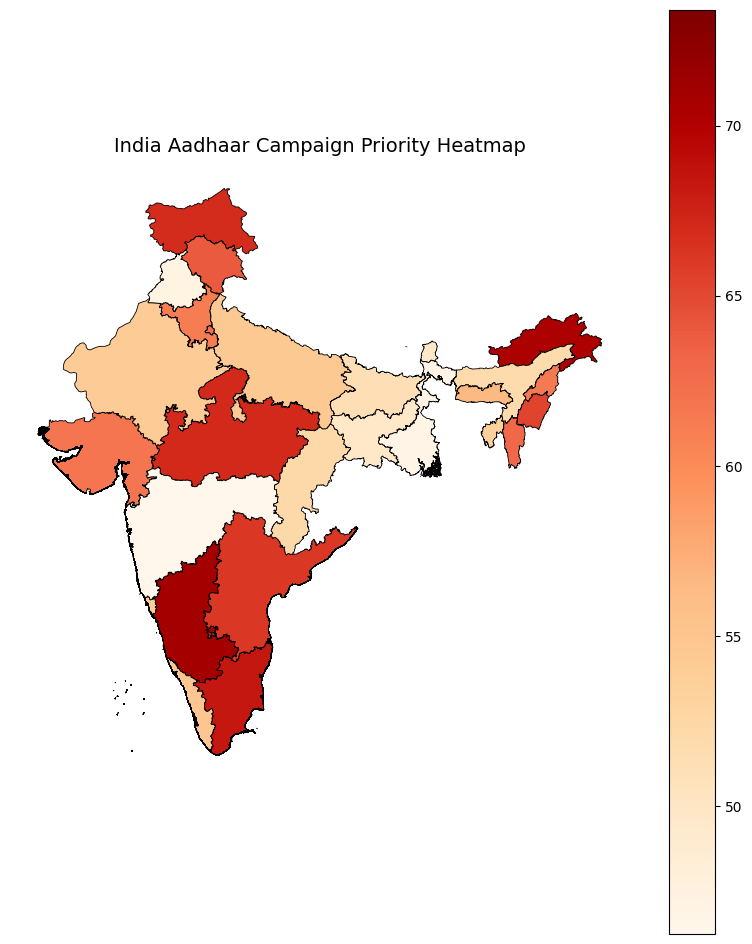

<Figure size 640x480 with 0 Axes>

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load India states geometry
india = gpd.read_file(
    'https://raw.githubusercontent.com/geohacker/india/master/state/india_state.geojson'
)

# Fix state names
india['state_clean'] = india['NAME_1'].str.lower()

# Merge with your heatmap data
map_df = india.merge(
    final_heatmap,
    on='state_clean',
    how='left'
)

# Plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

map_df.plot(
    column='heat_score',
    cmap='OrRd',
    linewidth=0.6,
    edgecolor='black',
    legend=True,
    ax=ax
)

ax.set_title('India Aadhaar Campaign Priority Heatmap', fontsize=14)
ax.axis('off')
top_states = map_df.nlargest(5, 'heat_score')



plt.show()
plt.savefig("india_aadhaar_campaign_heatmap.png", dpi=300, bbox_inches='tight')


In [ ]:
final_df['dominant_age_group_ratio'] = final_df['child_share'].apply(
    lambda x: 'School Age (5–17)' if x >= 0.15 else 'Adult & Youth (18+)'
)


In [ ]:
state_level_df = (
    final_df[['state_clean', 'dominant_age_group_ratio']]
    .drop_duplicates()
)

heatmap_table['dominant_age_group_ratio'] = heatmap_table['state_clean'].map(
    dict(
        state_level_df.set_index('state_clean')['dominant_age_group_ratio']
    )
)


In [ ]:
def campaign_color(row):
    if row['dominant_age_group_ratio'] == 'Adult & Youth (18+)':
        return 'Blue'
    elif row['heat_score'] >= 75:
        return 'Red'
    else:
        return 'Orange'



In [ ]:
heatmap_table['color_code'] = heatmap_table.apply(campaign_color, axis=1)
heatmap_table['color_code'].value_counts()


,count
color_code,
Blue,31
Orange,4
Red,1


In [ ]:
heatmap_table['color_code'] = (
    heatmap_table['color_code']
    .astype(str)
    .str.strip()
    .str.capitalize()
)
heatmap_table['color_code'].value_counts()



,count
color_code,
Blue,31
Orange,4
Red,1


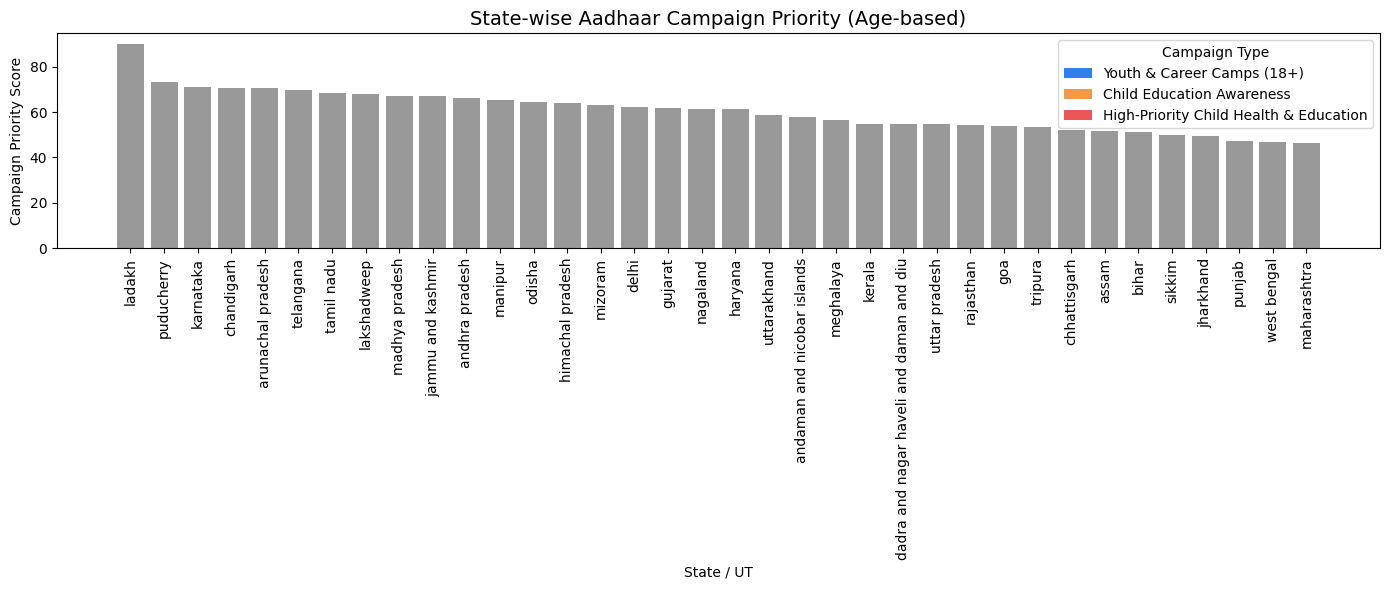

In [ ]:
plt.figure(figsize=(14,6))

plt.bar(
    plot_df['state_clean'],
    plot_df['heat_score'],
    color=colors
)

plt.title('State-wise Aadhaar Campaign Priority (Age-based)', fontsize=14)
plt.xlabel('State / UT')
plt.ylabel('Campaign Priority Score')
plt.xticks(rotation=90)

legend_elements = [
    Patch(facecolor='#2F80ED', label='Youth & Career Camps (18+)'),
    Patch(facecolor='#F2994A', label='Child Education Awareness'),
    Patch(facecolor='#EB5757', label='High-Priority Child Health & Education')
]

plt.legend(handles=legend_elements, title='Campaign Type')
plt.tight_layout()
plt.show()


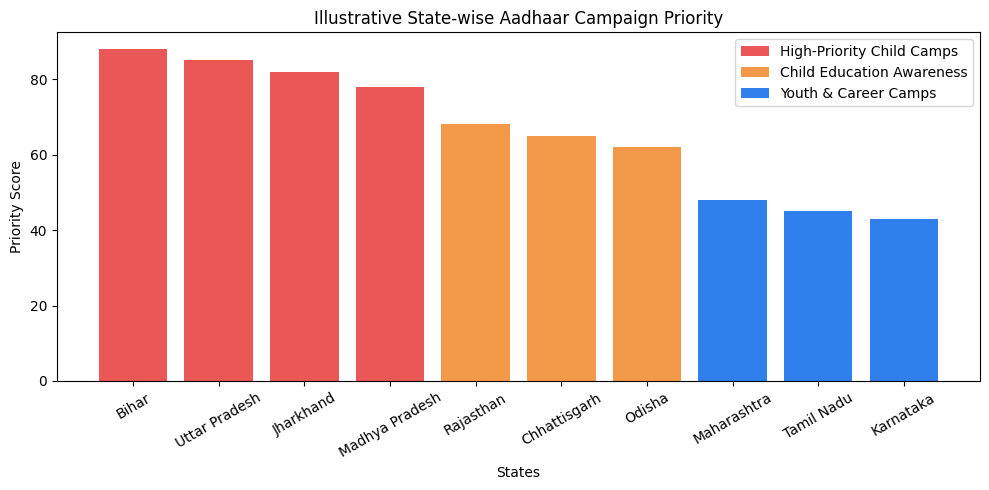

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

states = [
    'Bihar','Uttar Pradesh','Jharkhand','Madhya Pradesh',
    'Rajasthan','Chhattisgarh','Odisha',
    'Maharashtra','Tamil Nadu','Karnataka'
]

scores = [88, 85, 82, 78, 68, 65, 62, 48, 45, 43]

colors = [
    '#EB5757','#EB5757','#EB5757','#EB5757',   # Red
    '#F2994A','#F2994A','#F2994A',             # Orange
    '#2F80ED','#2F80ED','#2F80ED'              # Blue
]

plt.figure(figsize=(10,5))
plt.bar(states, scores, color=colors)
plt.title('Illustrative State-wise Aadhaar Campaign Priority')
plt.xlabel('States')
plt.ylabel('Priority Score')
plt.xticks(rotation=30)

plt.legend(handles=[
    Patch(facecolor='#EB5757', label='High-Priority Child Camps'),
    Patch(facecolor='#F2994A', label='Child Education Awareness'),
    Patch(facecolor='#2F80ED', label='Youth & Career Camps')
])

plt.tight_layout()
plt.show()
